# MNIST DiT

## Data Preparation

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import os

roots = ['/home/zhh24/data']
root = None
for root in roots:
    if os.path.exists(root):
        break
assert os.path.exists(root)

mnist = torchvision.datasets.MNIST(root, train=True, download=False, transform=transforms.ToTensor())

visualization has range: tensor(0.) tensor(1.)


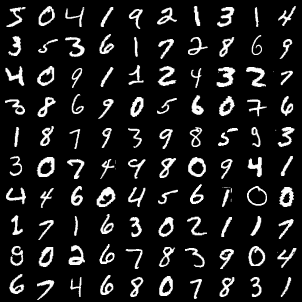

In [10]:
# visualization utils
from IPython.display import display, Image
from PIL import Image

def visualize_batch(batch, save_dir=None):
    B, C, H, W = batch.shape
    print('visualization has range:', batch.min(), batch.max())
    assert B >= 100, 'too small'
    grid = torchvision.utils.make_grid(batch[:100], nrow=10)
    np_image = grid.permute(1, 2, 0).mul_(255.).add_(0.5).clamp_(0., 255.).to(torch.uint8).numpy()
    pil_image = Image.fromarray(np_image)

    display(pil_image)
    if save_dir is not None:
        assert os.path.exists(os.path.dirname(save_dir))
        pil_image.save(save_dir)

visualize_batch(torch.stack([mnist[i][0] for i in range(100)], dim=0))

## Diffusion Trainer

For a brief review, we recall the DDPM formulation.

- General notation: $\alpha_t=\frac{\bar{\alpha}_t}{\bar{\alpha}_{t-1}}$
- Forward process: 
    - $x_t=\sqrt{\alpha_t}x_{t-1}+\sqrt{1-\alpha_t}\mathcal{N}(0,1)$
    - $x_t=\sqrt{\bar{\alpha}_t}x_0+\sqrt{1-\bar{\alpha}_t}\mathcal{N}(0,1)$

These are straightforward to understand. The derivation of the formula for the reverse process seems to be more complicated, so we derive it here.

- Epsilon prediction: $\epsilon_{\theta}(x_t, t)=\mathbb{E}_{x_0\sim p(x_0|x_t)}[\frac{x_t-\sqrt{\bar{\alpha}_t}x_0}{\sqrt{1-\bar{\alpha}_t}}]$
- Next step prediction: 
    - we want to approximate $p(x_{t-1}|x_t)$ using a Gaussian distribution:
    - We have: $p(x_{t-1}|x_t)=\int p(x_{t-1}|x_t,x_0)p(x_0|x_t)dx_0$
    - In practice, we can approximate $p(x_0|x_t)=\delta(x_0-\mathbb{E}_{x_0\sim p(x_0|x_t)}[x_0])$
    - Finally, we notice that $p(x_{t-1}|x_t,x_0)$ is a Gaussian due to Bayesian rule $p(x_t|x_{t-1}) \frac{p(x_{t-1}|x_0)}{p(x_t|x_0)}$
        - In this way we can compute the distribution $p(x_{t-1}|x_t)$, this is what DDPM paper does, but the derivation is complex.
        - New method (more steps, less calculation): notice that we can build a graph model:
            (TODO: add an image here)
            - $x_0, \epsilon_1\in \mathcal{N}(0,1), \epsilon_2\in \mathcal{N}(0,1)$ are independent;
            - $x_{t-1}=\sqrt{\bar{\alpha}_{t-1}}x_0+\sqrt{1-\bar{\alpha}_{t-1}}\epsilon_1$, and $x_t=\sqrt{{\alpha}_{t}}x_{t-1}+\sqrt{1-{\alpha}_{t}}\epsilon_2$
            - Then equivalently, we can consider $x_0, \epsilon_3, \epsilon_2$, where $\epsilon_3$ satisfies $x_t=\sqrt{\bar{\alpha}_t}x_0+\sqrt{1-\bar{\alpha}_t}\epsilon_3$. Note that $\epsilon_3$, $\epsilon_1$ and $\epsilon_2$ are related by the linear equation
            $$
            \sqrt{1-\bar{\alpha}_t}\epsilon_3 = \sqrt{\alpha_t}\sqrt{1-\bar{\alpha}_{t-1}}\epsilon_1 + \sqrt{1-\alpha_t}\epsilon_2
            $$
            - Thus, the distribution of $p(x_{t-1}|x_t,x_0)$ can be computed through $p(\epsilon_2|\epsilon_3, x_0)$. To find the latter, however, we directly notice that $\epsilon_3$ and
                $$
                \epsilon_4 := \frac{\sqrt{1-\alpha_t}\epsilon_1-\sqrt{\alpha_t}\sqrt{1-\bar{\alpha}_{t-1}}\epsilon_2}{\sqrt{1-\bar{\alpha}_t}}
                $$
                are independent and are both $\mathcal{N}(0,1)$. Thus, one simply yield
                $$
                \epsilon_2 = \frac{\sqrt{1-\alpha_t}\epsilon_3-\sqrt{\alpha_t}\sqrt{1-\bar{\alpha}_{t-1}}\epsilon_4}{\sqrt{1-\bar{\alpha}_t}}
                $$
                - Finally, notice that with the delta function multiplied, $\epsilon_3=\epsilon_\theta(x_t,t)$. This gives
                $$
                x_{t-1}=\frac{1}{\sqrt{\alpha_t}}\left(x_t-\sqrt{1-\alpha_t}\frac{\sqrt{1-\alpha_t}\epsilon_\theta(x_t,t)-\sqrt{\alpha_t}\sqrt{1-\bar{\alpha}_{t-1}}\epsilon_4}{\sqrt{1-\bar{\alpha}_t}}\right)
                $$

            This formula is equivalent to the one in the paper, but is more intuitive (see the explanation below: TODO)

Anyway, let's start coding with

$$
x_{t-1}=\frac{1}{\sqrt{\alpha_t}}\left(x_t-\frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}}\epsilon_\theta(x_t,t)\right) + \sqrt{\frac{1-\bar{\alpha}_{t-1}}{1-\bar{\alpha}_{t}}(1-\alpha_t)}\mathcal{N}(0,1)
$$

In [14]:
import math
import tqdm

class Diffusion:
    
    def __init__(self, T, schedule='cosine', image_size=(1, 28, 28), num_classes=10):
        self.T = T
        self.image_size = image_size
        self.num_classes = num_classes

        if schedule == 'cosine':
            # cosine schedule
            self.alpha_bar = torch.cos(math.pi * torch.linspace(0.01, 0.99, T)) * 0.5 + 0.5 # debug
            # self.alpha_bar = torch.cos(math.pi * torch.linspace(0.001, 0.999, T)) * 0.5 + 0.5
            self.alpha_bar_pre = torch.ones_like(self.alpha_bar, dtype=torch.float32)
            self.alpha_bar_pre[1:] = self.alpha_bar[:-1]
            self.alpha = self.alpha_bar / self.alpha_bar_pre
        else:
            raise NotImplementedError(schedule)

    def pre_process(self, x):
        return x * 2.0 - 1.0
    
    def post_process(self, x):
        return x * 0.5 + 0.5
        
    def loss(self, model, image_batch, label_batch):
        x0 = self.pre_process(image_batch)
        eps = torch.randn_like(x0)
        B, *imgsize = x0.shape
        assert tuple(imgsize) == self.image_size, (imgsize, self.image_size)
        
        t = torch.rand((B,))
        toimg = lambda z: z.reshape(-1, 1, 1, 1)

        xt = toimg(t) * x0 + toimg(1 - t) * eps
        loss = F.mse_loss(model(xt, t * self.T, y=label_batch), (xt).cuda())
        # loss = F.mse_loss(model(xt, t * self.T, y=label_batch), (x0 - eps).cuda())
        return loss
        

        # x0 = self.pre_process(image_batch)
        # eps = torch.randn_like(x0)
        # B, *imgsize = x0.shape
        # assert tuple(imgsize) == self.image_size, (imgsize, self.image_size)
        # t = torch.randint(0, self.T, (B,))

        # toimg = lambda z: z.reshape(-1, 1, 1, 1)

        # xt = toimg(self.alpha_bar[t]) ** 0.5 * x0 + toimg(1 - self.alpha_bar[t]) ** 0.5 * eps
        # loss = F.mse_loss(model(xt, t, y=label_batch), eps.cuda())
        # return loss
    
    def get_sample_schedule(self, sample_steps):
        return

        self.use_ts = torch.linspace(0, self.T - 1, sample_steps + 1).round().to(torch.long)[1:]
        self.sample_alpha_bars = self.alpha_bar[self.use_ts]
        self.sample_alpha_bars_pre = torch.ones_like(self.sample_alpha_bars)
        self.sample_alpha_bars_pre[1:] = self.sample_alpha_bars[:-1]
        self.sample_alpha = self.sample_alpha_bars / self.sample_alpha_bars_pre
    
    @torch.no_grad()
    def sample(self, model, sample_steps, num_samples=100):
        x = torch.randn(num_samples, *self.image_size).cuda()
        y = torch.arange(self.num_classes).repeat(num_samples // self.num_classes + 1)[:num_samples]
        
        for idx in tqdm.trange(sample_steps, desc='Sampling'):
            x += model(x, torch.tensor([idx * self.T / sample_steps]).repeat(num_samples, ), y=y) / sample_steps

        return self.post_process(x.cpu())


        self.get_sample_schedule(sample_steps)

        x = torch.randn(num_samples, *self.image_size).cuda()
        y = torch.arange(self.num_classes).repeat(num_samples // self.num_classes + 1)[:num_samples]
        for idx in tqdm.trange(sample_steps - 1, -1, -1, desc='Sampling'):
            t = self.use_ts[idx]
            alpha = self.sample_alpha[idx].cuda()
            alpha_bar = self.sample_alpha_bars[idx].cuda()
            alpha_bar_pre = self.sample_alpha_bars_pre[idx].cuda()

            x = alpha ** -0.5 * (
                x - (1 - alpha) * model(x, t.repeat(num_samples,), y=y)
            ) + ((1 - alpha_bar_pre) / (1 - alpha_bar) * (1 - alpha)) ** 0.5 * torch.randn_like(x)

        return self.post_process(x.cpu())

In [15]:
import torch.utils
import torch.utils.data
from model import DiT_base

class Avger(list):
    def __str__(self):
        return f'{sum(self)/len(self):.4f}' if self else 'N/A'

def train(net, num_epochs, lr=4e-4, sample_per=4, batch_size=512, diffusion_T=1000, sample_steps=100):
    assert not isinstance(net, nn.DataParallel)
    loader = torch.utils.data.DataLoader(mnist, batch_size=batch_size)
    net = nn.DataParallel(net.cuda())
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    diffusion = Diffusion(diffusion_T)

    for epoch in range(num_epochs):
        if epoch % sample_per == 0:
            net.eval()
            image = diffusion.sample(net, sample_steps=sample_steps)
            visualize_batch(image, f'./{epoch:02d}.png')
            torch.save(net.module.state_dict(), f'./{epoch:02d}.pth')

        net.train()
        losses = Avger()
        with tqdm.tqdm(loader) as bar:
            for x, y in bar:
                loss = diffusion.loss(net, x, y)
                opt.zero_grad()
                loss.backward()
                opt.step()
                losses.append(loss.item())
                bar.set_description(f'Epoch {epoch}/{num_epochs}, Loss {losses}')


num of model parameters: 8149060


Sampling:   0%|                                                                                                                    | 0/100 [00:00<?, ?it/s]/nobackup/users/zhh24/anaconda3/envs/DYY/lib/python3.7/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.80it/s]

visualization has range: tensor(-1.5241) tensor(2.6534)


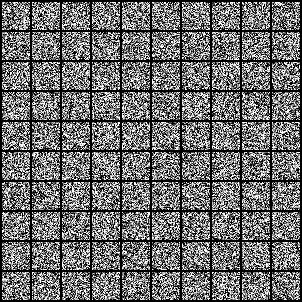

Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.85it/s]

visualization has range: tensor(-3.3683) tensor(3.9695)


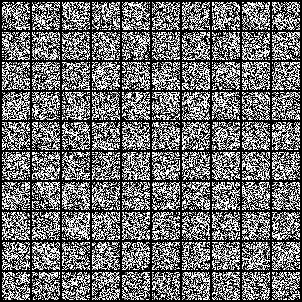

Epoch 4/50, Loss 0.0003:  84%|█████████████████████████████████████████████████████████████████████████████▏              | 99/118 [00:45<00:08,  2.18it/s]


KeyboardInterrupt: 

In [16]:
net = DiT_base()
print('num of model parameters:', sum(p.numel() for p in net.parameters()))
train(net, 50)